In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog
import numpy as np
import pandas as pd
from PIL import Image
from skimage import data, exposure
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm

In [3]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import util
import surf_hog_analysis 

In [ ]:
!pip install seaborn

In [ ]:
!pip install imblearn

In [ ]:
!pip install scikit-learn

---

### Data preparation

In [4]:
df = pd.read_csv('data/train_complete.csv')

In [5]:
# Count occurrences of `ImageId` in df
#df['count'] = df.ImageId.apply(lambda x: df['ImageId'].value_counts()[x])

---

# KNN

---

## Use HoG Feature Vector (based on 4 imbalanced classes in train_images) in KNN

In [6]:
hog = pd.read_csv('data/train_HOG.csv')

In [7]:
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(hog)

In [8]:
hog_complete = hog.merge(df[['ClassId','ImageId']], on = 'ImageId')
hog_complete.head()

,0,1,2,3,4,5,6,7,8,9,...,3772,3773,3774,3775,3776,3777,3778,3779,ImageId,ClassId
0,0.260472,0.168138,0.260472,0.124914,0.117598,0.000000,0.023278,0.078617,0.071638,0.125196,...,0.048746,0.040422,0.015478,0.129134,0.126747,0.194180,0.159938,0.224502,58ee62fd7.jpg,3
1,0.233020,0.233020,0.233020,0.221273,0.198087,0.087594,0.057336,0.024053,0.085179,0.192792,...,0.048371,0.032045,0.092339,0.158407,0.255698,0.255698,0.255698,0.049551,0dced41aa.jpg,0
2,0.199433,0.128030,0.110016,0.008214,0.155047,0.088910,0.155657,0.077873,0.260184,0.260184,...,0.080780,0.033171,0.142762,0.186500,0.197350,0.193555,0.223840,0.068564,bd2366c49.jpg,0
3,0.357059,0.189545,0.000000,0.004834,0.050835,0.033951,0.123951,0.057806,0.084447,0.357059,...,0.050235,0.024185,0.011188,0.037392,0.007501,0.008185,0.022333,0.227738,e2bdd4236.jpg,3
4,0.148689,0.130765,0.193046,0.264011,0.266173,0.134977,0.046870,0.030897,0.026977,0.115430,...,0.102538,0.195246,0.184212,0.225130,0.222193,0.224301,0.075570,0.216802,5210ac609.jpg,3


In [9]:
# eliminate class 0 in dataframe
hog_complete = hog_complete.query('ClassId != 0')

In [10]:
hog_complete.groupby('ClassId')['ImageId'].count()

ClassId
1     769
2     195
3    4759
4     516
Name: ImageId, dtype: int64

In [11]:
#Split Hog_complete in X und Y
X = hog_complete.drop(['ClassId','ImageId'], axis =1)
y = hog_complete['ClassId']

In [12]:
from sklearn.model_selection import train_test_split
# Split without oversampled data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state = 42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(4991, 3780), (4991,)
Test data and target sizes: 
(1248, 3780), (1248,)


In [ ]:
#Oversampling with RandomOversampler
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [ ]:
#Oversampling with SMOTE
X_train_smo, y_train_smo = SMOTE().fit_resample(X_train, y_train)

In [13]:
test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
#X_train_scaled = scaler.fit_transform(X_train_ros)
#X_train_scaled = scaler.fit_transform(X_train_smo)
X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)
#classifier.fit(X_train_scaled, y_train_ros)
#classifier.fit(X_train_scaled, y_train_smo)

y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

0.7940705128205128


[[121   6  27   0]
 [  9  24   6   0]
 [ 90  16 846   0]
 [ 29   0  74   0]]


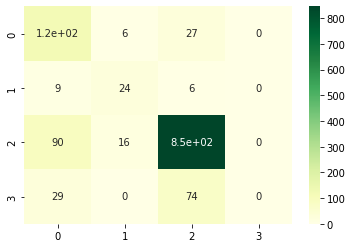

In [14]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [15]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.49      0.79      0.60       154
           2       0.52      0.62      0.56        39
           3       0.89      0.89      0.89       952
           4       0.00      0.00      0.00       103

    accuracy                           0.79      1248
   macro avg       0.47      0.57      0.51      1248
weighted avg       0.75      0.79      0.77      1248



/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set 

#### results without oversampling   
    
           precision    recall  f1-score   support

           0       0.74      0.88      0.81      1181
           1       0.46      0.56      0.51       154
           2       0.38      0.72      0.50        39
           3       0.87      0.70      0.77       952
           4       0.67      0.02      0.04       103

    accuracy                           0.75      2429
   macro avg       0.63      0.58      0.53      2429
weighted avg       0.77      0.75      0.74      2429

#### results with random oversampling  
           precision    recall  f1-score   support

           0       0.80      0.80      0.80      1181
           1       0.35      0.73      0.47       154
           2       0.31      0.82      0.45        39
           3       0.85      0.71      0.77       952
           4       0.44      0.11      0.17       103

    accuracy                           0.73      2429
   macro avg       0.55      0.63      0.53      2429
weighted avg       0.77      0.73      0.74      2429

#### results with SMOTE oversampling  
            precision    recall  f1-score   support

           0       0.98      0.39      0.55      1181
           1       0.15      0.85      0.25       154
           2       0.17      0.87      0.29        39
           3       0.87      0.53      0.66       952
           4       0.19      0.56      0.28       103

    accuracy                           0.49      2429
   macro avg       0.47      0.64      0.41      2429
weighted avg       0.84      0.49      0.56      2429

---

### Visualization of falsely predicted pictures

In [ ]:
#surf_hog_analysis.print_false_classifications(df, hog_complete, y_test, y_pred)

---

#### Piece-by-piece visualization

In [16]:
# extract indices of our `hog_complete` data frame where predictions were incorrect
false_predictions = (y_pred!=y_test)
false_predictions = false_predictions[false_predictions].index.values

In [17]:
y_pred[(y_pred!=y_test)]

array([1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3,
       3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 2, 3, 1, 2, 1, 3, 3, 3,
       1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 2, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3,
       3, 3, 1, 2, 3, 2, 3, 1, 3, 3, 3, 3, 2, 2, 1, 3, 3, 1, 1, 3, 1, 1,
       1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3,
       3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3,
       1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 3, 1, 1, 2, 3, 1, 1,
       2, 1, 3, 2, 1, 3, 3, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 2, 1, 3, 3, 3,
       3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1,
       1, 1, 2, 3, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 2, 1,
       3, 3, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 1, 1, 1, 3, 1, 3,
       1, 1, 3, 2, 1, 3, 3, 1, 1, 2, 1, 1, 1, 3, 3])

In [18]:
y_pred_false =y_pred[(y_pred!=y_test)]

predictions = pd.DataFrame(y_pred_false, index=false_predictions,columns=['ClassId_predicted'])
predictions

,ClassId_predicted
5869,1
7749,3
5883,2
11573,1
10144,1
...,...
2184,1
6826,1
5375,1
7204,3


In [19]:
# extract all rows from `hog_complete` where the predcition was incorrect
false_predicted_images = hog_complete.join(predictions).loc[false_predictions][['ImageId','ClassId', 'ClassId_predicted']]
# add additional information needed to find the correponding pictures
false_predicted_images = false_predicted_images.merge(df[['FilePath','ImageId']], on = 'ImageId')


In [20]:
false_predicted_images

,ImageId,ClassId,ClassId_predicted,FilePath
0,354760e3e.jpg,3,1.0,/Users/fabioteichmann/neuefische/projects/Caps...
1,79c106c42.jpg,4,3.0,/Users/fabioteichmann/neuefische/projects/Caps...
2,995ef2622.jpg,3,2.0,/Users/fabioteichmann/neuefische/projects/Caps...
3,db62a970a.jpg,4,1.0,/Users/fabioteichmann/neuefische/projects/Caps...
4,5698f3507.jpg,4,1.0,/Users/fabioteichmann/neuefische/projects/Caps...
...,...,...,...,...
252,d238605c1.jpg,2,1.0,/Users/fabioteichmann/neuefische/projects/Caps...
253,991e0dfdf.jpg,3,1.0,/Users/fabioteichmann/neuefische/projects/Caps...
254,9ec897b68.jpg,3,1.0,/Users/fabioteichmann/neuefische/projects/Caps...
255,baca6503a.jpg,4,3.0,/Users/fabioteichmann/neuefische/projects/Caps...


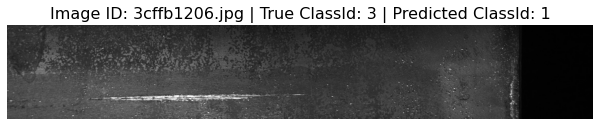

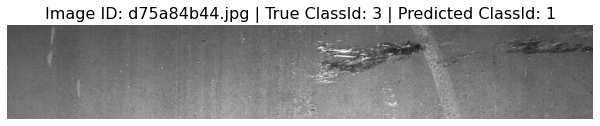

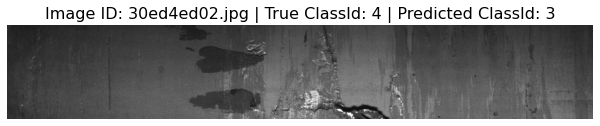

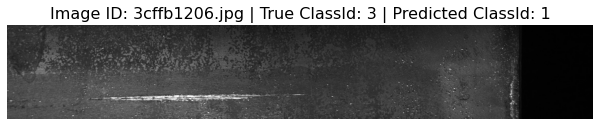

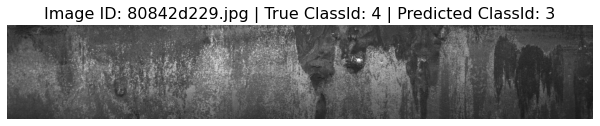

In [26]:
number_images = 5

random_index = np.round(np.random.rand(number_images) * len(false_predicted_images.ImageId)) + 1
#print(random_index)

for i in range(number_images):
    #random_index = 'random_index_' + str(i+1)
    #print(random_index)
    file_path_to_image = false_predicted_images['FilePath'][random_index[i]]
    class_id = false_predicted_images['ClassId'][random_index[i]]
    image_id = false_predicted_images['ImageId'][random_index[i]]
    class_id_pred = int(false_predicted_images['ClassId_predicted'][random_index[i]])
    
    img = io.imread(file_path_to_image)
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(number_images, 1, i + 1)
    plt.imshow(img)
    plt.title(f'Image ID: {image_id} | True ClassId: {class_id} | Predicted ClassId: {class_id_pred}', fontsize=16);
    plt.axis("off")
    
"""
file_path_to_image = false_predicted_images['FilePath'][random_index]
class_id = false_predicted_images['ClassId'][random_index]
image_id = false_predicted_images['ImageId'][random_index]
class_id_pred = int(false_predicted_images['ClassId_predicted'][random_index])
print(image_id)

img = io.imread(file_path_to_image)

plt.figure(figsize=(18, 3))
plt.imshow(img)
plt.title(f'Image ID: {image_id} | True ClassId: {class_id} | Predicted ClassId: {class_id_pred}', fontsize=16);
""";

To understand the high rate of misclassifications for `ClassId` 3, we will visualize images from our prediction

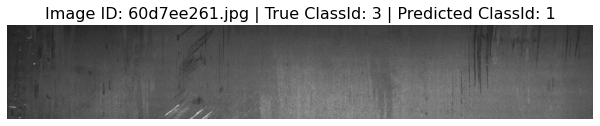

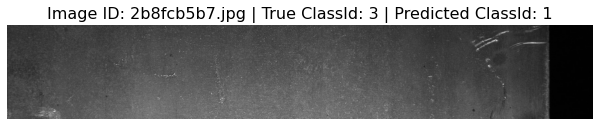

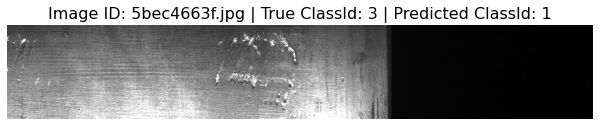

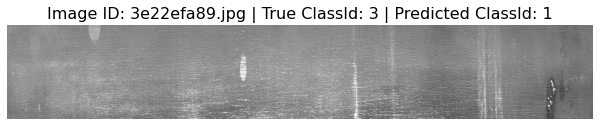

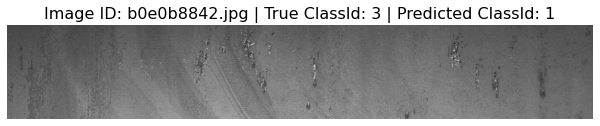

In [39]:
# visualize pictures from `ClassId` 3 with their predictions

number_images = 5
f_pred_img_class3 = false_predicted_images.query('ClassId == 3')

random_index = np.round(np.random.rand(number_images) * len(f_pred_img_class3.ImageId)) + 1
#print(random_index)

for i in range(number_images):
    #random_index = 'random_index_' + str(i+1)
    #print(random_index)
    file_path_to_image = f_pred_img_class3['FilePath'].iloc[int(random_index[i])]
    class_id = f_pred_img_class3['ClassId'].iloc[int(random_index[i])]
    image_id = f_pred_img_class3['ImageId'].iloc[int(random_index[i])]
    class_id_pred = int(f_pred_img_class3['ClassId_predicted'].iloc[int(random_index[i])])
    
    img = io.imread(file_path_to_image)
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(number_images, 1, i + 1)
    plt.imshow(img)
    plt.title(f'Image ID: {image_id} | True ClassId: {class_id} | Predicted ClassId: {class_id_pred}', fontsize=16);
    plt.axis("off")

## Use HoG Feature Vector (based on augmented train_images; balanced) in KNN
#### Use augmented hog pictures for Training an initial hog pictures (hog_complete) for test

---
### Version Fabio

In [49]:
df_train = pd.read_csv('data/train_set_augmented.csv')
df_test = pd.read_csv('data/test_set_for_augmented.csv')

In [78]:
# retrieve hog features for test images
ids = df_test.ImageId.to_list()
df_test_hog = hog_complete.query('ImageId == @ids')

In [79]:
# retrieve data from augmentation split
X_test = df_test_hog.copy()
X_test.pop('ImageId')
y_test = X_test.pop('ClassId')

In [53]:
# augmented pictures are based on single defect pictures of classes 1-4
hog_augmented = pd.read_csv('data/train_HOG_augmented.csv')
hog_augmented = pd.merge(hog_augmented, df_train[['ImageId', 'ClassId']], on='ImageId')

In [54]:
hog_augmented.head(2)

,0,1,2,3,4,5,6,7,8,9,...,3772,3773,3774,3775,3776,3777,3778,3779,ImageId,ClassId
0,0.205749,0.020419,0.053911,0.040776,0.151213,0.035963,0.026568,0.043647,0.045924,0.301900,...,0.002411,0.000000,0.000000,0.005869,0.000000,0.003658,0.015156,0.308759,aug_1560_463fe382b.jpg,2
1,0.222286,0.147507,0.222286,0.159192,0.149158,0.124433,0.192710,0.196143,0.165258,0.222286,...,0.180468,0.036341,0.015886,0.186793,0.115691,0.151751,0.115101,0.256424,aug_2013_0645d69f9.jpg,3


In [55]:
X_train = hog_augmented.copy()
X_train.pop('ImageId')
y_train = X_train.pop('ClassId')

In [94]:
test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
#X_train_scaled = scaler.fit_transform(X_train_ros)
#X_train_scaled = scaler.fit_transform(X_train_smo)
X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)
#classifier.fit(X_train_scaled, y_train_ros)
#classifier.fit(X_train_scaled, y_train_smo)

y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

0.5725160256410257


[[ 250   32   25    2]
 [   8   65    3    0]
 [ 550  183 1089   71]
 [ 119    6   68   25]]


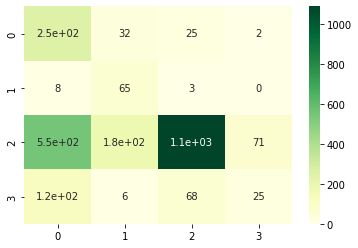

In [92]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [88]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.25      0.86      0.38       309
           2       0.22      0.84      0.35        76
           3       0.92      0.53      0.67      1893
           4       0.18      0.04      0.06       218

    accuracy                           0.54      2496
   macro avg       0.39      0.57      0.37      2496
weighted avg       0.75      0.54      0.57      2496



---
### Version Daniela

In [ ]:
df2 = pd.read_csv('data/train_single_defects_augmented.csv')
df2.head()

In [ ]:
# augmented pictures are based on single defect pictures of classes 1-4
hog_augmented = pd.read_csv('data/train_HOG_augmented.csv')
hog_augmented.head()

In [ ]:
hog_augmented_complete = hog_augmented.merge(df2[['ClassId','ImageId']], on = 'ImageId')
hog_augmented_complete.head()

In [ ]:
hog_augmented_complete.groupby('ClassId')['ImageId'].count()

In [ ]:
# Idea: use augmented hog pictures for Training an initial hog pictures (hog_complete) for test
#Split Hog_complete in X und Y
X_train = hog_augmented_complete.drop(['ClassId','ImageId'], axis =1)
y_train = hog_augmented_complete['ClassId']

# eliminate "class 0" in hog_complete
hog_complete2 = hog_complete.query('ClassId != 0')
X_test = hog_complete2.drop(['ClassId','ImageId'], axis =1)
y_test = hog_complete2['ClassId']
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

In [ ]:

test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)


y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(y_test, y_pred))

###  same model without class 3

In [ ]:

#Idea: use augmented hog pictures for Training an initial hog pictures (hog_complete) for test
#Split Hog_complete in X und Y
# eliminate "class 3 " in hog_augmented_complete
hog_augmented_complete2 = hog_augmented_complete.query('ClassId != 3') 
X_train = hog_augmented_complete2.drop(['ClassId','ImageId'], axis =1)
y_train = hog_augmented_complete2['ClassId']

# eliminate "class 3" in hog_complete2 (Class 0 is already eliminated)
hog_complete3 = hog_complete2.query('ClassId != 3')
X_test = hog_complete3.drop(['ClassId','ImageId'], axis =1)
y_test = hog_complete3['ClassId']
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

In [ ]:

test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)


y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(y_test, y_pred))

#### Use augmented hog feature Vector for Training and test (split data)

In [ ]:
#hog_augmented_complete2 = hog_augmented_complete.query('ClassId != 3') 
X = hog_augmented_complete.drop(['ClassId','ImageId'], axis =1)
y = hog_augmented_complete['ClassId']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state = 42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

In [ ]:
test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)


y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(y_test, y_pred))

### Use augmented hog feature Vector for Training and test (split data) with Blur!

In [ ]:
# augmented pictures are based on single defect pictures of classes 1-4
hog_augmented_blur = pd.read_csv('data/train_HOG_augmented_blur.csv')
hog_augmented_blur.head()

In [ ]:
hog_augmented_blur_complete = hog_augmented_blur.merge(df2[['ClassId','ImageId']], on = 'ImageId')
hog_augmented_blur_complete.shape

In [ ]:
#hog_augmented_blur_complete2 = hog_augmented_blur_complete.query('ClassId != 3') 
X = hog_augmented_blur_complete.drop(['ClassId','ImageId'], axis =1)
y = hog_augmented_blur_complete['ClassId']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state = 42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

In [ ]:
test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)


y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(y_test, y_pred))

---

## SURF

In [95]:
surf = pd.read_csv('data/train_surf.csv')

In [96]:
util.isolate_single_defects(surf)

,keypoints,ImageId,NumberKP,kp_x_1,kp_y_1,kp_size_1,kp_x_2,kp_y_2,kp_size_2,kp_x_3,...,kp_x_48,kp_y_48,kp_size_48,kp_x_49,kp_y_49,kp_size_49,kp_x_50,kp_y_50,kp_size_50,ClassId
0,"(<KeyPoint 0x11f5da180>, <KeyPoint 0x14ef7a840...",58ee62fd7.jpg,290,648.023193,123.642967,185.0,630.717224,125.520142,115.0,1061.775757,...,1210.694702,120.774101,28.0,761.897278,200.103256,28.0,892.589294,180.906418,28.0,3
3,"(<KeyPoint 0x14f032420>, <KeyPoint 0x14f032450...",e2bdd4236.jpg,55,179.406067,212.326080,43.0,164.187988,165.483612,42.0,138.280975,...,1484.858398,158.782227,15.0,1195.419800,101.514122,14.0,711.726135,67.232407,14.0,3
4,"(<KeyPoint 0x14f032e70>, <KeyPoint 0x14f032ea0...",5210ac609.jpg,158,927.698486,92.710060,68.0,593.447815,155.911697,63.0,590.091309,...,943.871094,234.400726,22.0,980.921692,212.030716,22.0,440.769836,189.693359,22.0,3
7,"(<KeyPoint 0x14f0ded80>, <KeyPoint 0x14f0dedb0...",48831ab9e.jpg,8,732.521118,225.334747,34.0,844.692566,215.891281,23.0,733.067993,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3
9,"(<KeyPoint 0x14f0efb40>, <KeyPoint 0x14f0efb70...",d5cf4a417.jpg,878,541.276978,125.816437,165.0,408.338135,119.352188,125.0,470.891968,...,473.591339,97.862251,54.0,597.812439,122.404388,53.0,516.593689,165.010345,53.0,3


In [105]:
surf_complete = surf.merge(df[['ClassId','ImageId']], on = 'ImageId')
surf_complete = surf_complete.query('ClassId != 0')

In [107]:
# Drop irrelevant columns and split surf_complete into X and y
X_surf = surf_complete.drop(['ClassId','ImageId','keypoints'], axis =1)
y_surf = surf_complete['ClassId']

In [108]:
# Split without oversampled data
X_train, X_test, y_train, y_test = train_test_split(X_surf, y_surf, test_size=0.2, 
                                                    stratify=y_surf, random_state=42)

In [109]:
test_accuracy = []
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

0.717948717948718


[[ 38   5 110   1]
 [  7   2  30   0]
 [ 67  10 855  20]
 [  2   1  99   1]]


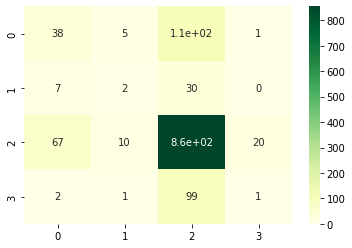

In [110]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [111]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.33      0.25      0.28       154
           2       0.11      0.05      0.07        39
           3       0.78      0.90      0.84       952
           4       0.05      0.01      0.02       103

    accuracy                           0.72      1248
   macro avg       0.32      0.30      0.30      1248
weighted avg       0.64      0.72      0.68      1248



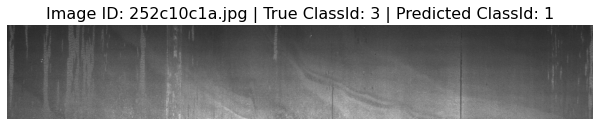

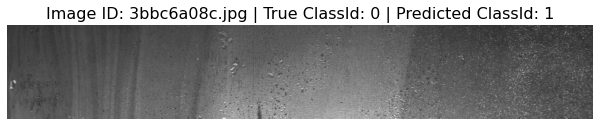

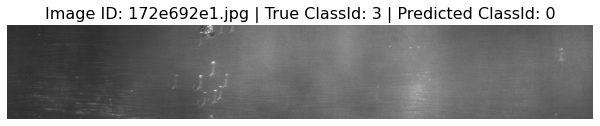

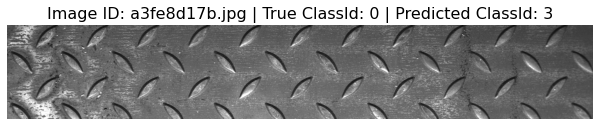

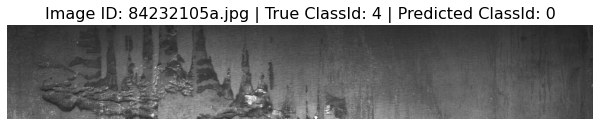

In [103]:
# print out several misclassified images
surf_hog_analysis.print_false_classifications(df, surf_complete, y_test, y_pred)

---

# SVM

In [ ]:
svm_model = svm.SVC(kernel='rbf', gamma=0.001, C = 100)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = svm_model.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
#Oversampling
ros = RandomOverSampler(random_state=42)
X_sros, y_sros = ros.fit_resample(X_train, y_train)

In [ ]:
test_accuracy = []
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sros)
X_test_scaled = scaler.transform(X_test)

svm_model.fit(X_train_scaled, y_sros)

y_pred = svm_model.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'kernel': ['rbf'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 
               'C': [1, 10, 100, 1000]}]

grid = GridSearchCV(model, param_grid, verbose=True, n_jobs=-1)

result = grid.fit(X_train, y_train)

In [ ]:
# Print best parameters 
print('Best Parameters:', result.best_params_)

# Print best score
print('Best Score:', result.best_score_)

In [ ]:
surf_complete.groupby(['ClassId']).mean().NumberKP